<a href="https://colab.research.google.com/github/samrat-m/mai-prac/blob/main/Pre_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 1: Showing Fine-Tuning vs Pre-Training

In [ ]:
# Ignore insignificant warnings (ex: deprecations)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set a seed for reproducibility
import torch

def fix_torch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_torch_seed()

In [ ]:
from transformers import AutoModelForCausalLM
tiny_general_model = AutoModelForCausalLM.from_pretrained(
    "upstage/TinySolar-248m-4k", #https://huggingface.co/upstage/TinySolar-248m-4k
    device_map="auto", # change to auto if you have access to a GPU
    torch_dtype=torch.bfloat16
)

In [ ]:
from transformers import AutoTokenizer
tiny_general_tokenizer = AutoTokenizer.from_pretrained(
    "upstage/TinySolar-248m-4k"
)

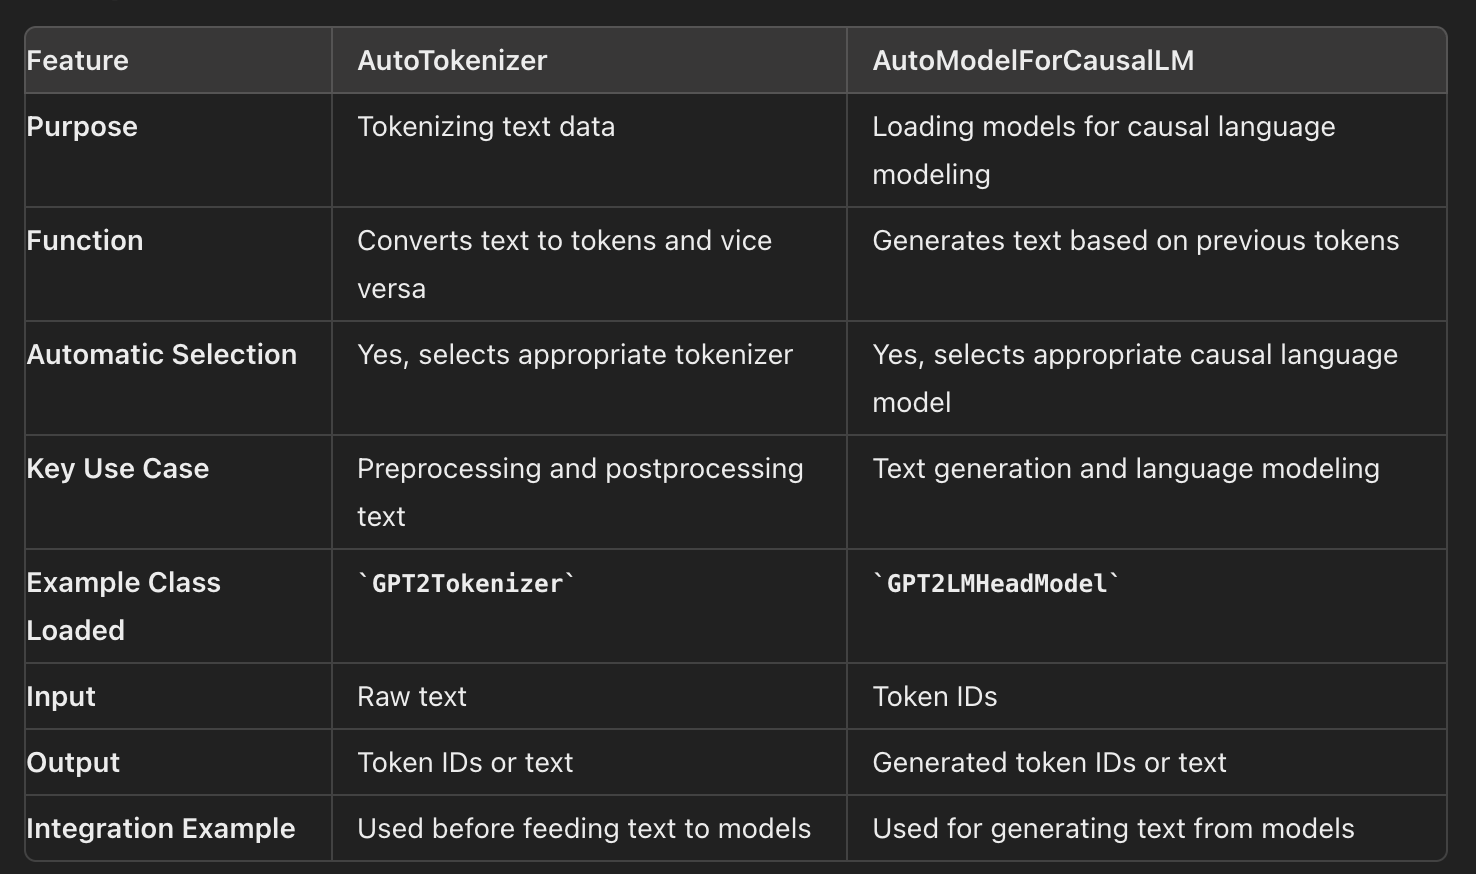

In [ ]:
prompt = "I am an engineer. I love"

In [ ]:
inputs = tiny_general_tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[    1,   315,   837,   396, 18112, 28723,   315,  2016]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

## Wrapping this into a general purpose function
1. Tokenize
2. Stream
3. Generate

In [ ]:
from transformers import TextStreamer
def generate_output(prompt, model, tokenizer):
  inputs = tokenizer(prompt, return_tensors="pt")
  streamer = TextStreamer(
    tokenizer,
    skip_prompt=True, # If you set to false, the model will first return the prompt and then the generated text
    skip_special_tokens=True
  )
  outputs = model.generate(
    **inputs,
    streamer=streamer,
    use_cache=True,
    max_new_tokens=128,
    do_sample=False,
    temperature=0.0,
    repetition_penalty=1.1
  )
  print(outputs)



In [ ]:
generate_output(prompt, tiny_general_model, tiny_general_tokenizer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


to travel and have a great time, but I'm not sure if I can do it all again.
I've been working on my first book for the last 10 years, and I've always wanted to write about something that has happened in my life. It's been a long journey, but I've finally found my voice. I've written a lot of books, and I've had some really good ones. I've also written a few short stories, which are very different from what I'd normally write.
I've been writing fiction since I was 12
tensor([[    1,   315,   837,   396, 18112, 28723,   315,  2016,   298,  4530,
           304,   506,   264,  1598,   727, 28725,   562,   315, 28742, 28719,
           459,  1864,   513,   315,   541,   511,   378,   544,  1076, 28723,
            13, 28737, 28742,   333,   750,  2739,   356,   586,   907,  1820,
           354,   272,  1432, 28705, 28740, 28734,  1267, 28725,   304,   315,
         28742,   333,  1743,  2613,   298,  3324,   684,  1545,   369,   659,
          4243,   297,   586,  1411, 28723,   661, 2874

## Let's now do a different task

In [ ]:
prompt =  "def find_max(numbers):"
generate_output(prompt, tiny_general_model, tiny_general_tokenizer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



       """
       Returns the number of times a user has been added to the list.
       """
       return num_users() + 1

   def get_user_id(self, id):
       """
       Returns the number of users that have been added to the list.
       """
       return self._get_user_id(id)

   def get_user_name(self, name):
       """
       Returns the name of the user that has been added to the list.
       """
       return self._get_user_name(name
tensor([[    1,   801,  1300, 28730,  2416, 28732,  2575,  1891,  1329,    13,
          5390,  3504,    13,  5390,  6699,   272,  1474,   302,  2421,   264,
          2188,   659,   750,  3886,   298,   272,  1274, 28723,    13,  5390,
          3504,    13,  5390,   604,  2075, 28730, 10247,   470,   648, 28705,
         28740,    13,    13,  2287,   801,   625, 28730,  1838, 28730,   313,
         28732,   944, 28725,  1910,  1329,    13,  5390,  3504,    13,  5390,
          6699,   272,  1474,   302,  5443,   369,   506,   750,  3886,   298,
 

## Since it is bad, we would use a model that is better at doing python code.


In [ ]:
model_path_or_name = "upstage/TinySolar-248m-4k-code-instruct"
python_ft_model = AutoModelForCausalLM.from_pretrained(
    model_path_or_name,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
python_ft_tokenizer = AutoTokenizer.from_pretrained(
    model_path_or_name
)

generate_output(prompt, python_ft_model, python_ft_tokenizer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



   if len(numbers) == 0:
       return "Invalid input"
   else:
       return max(numbers)
```

In this solution, the `find_max` function takes a list of numbers as input and returns the maximum value in that list. It then iterates through each number in the list and checks if it is greater than or equal to 1. If it is, it adds it to the `max` list. Finally, it returns the maximum value found so far.
tensor([[    1,   801,  1300, 28730,  2416, 28732,  2575,  1891,  1329,    13,
          2287,   513,  3919, 28732,  2575,  1891, 28731,   859, 28705, 28734,
         28747,    13,  5390,   604,   345,  6976,  2787, 28739,    13,  2287,
          1112, 28747,    13,  5390,   604,  2666, 28732,  2575,  1891, 28731,
            13, 13940, 28832,    13,    13,   657,   456,  5165, 28725,   272,
          1552,  3326, 28730,  2416, 28832,   908,  4347,   264,  1274,   302,
          5551,   390,  2787,   304,  5723,   272,  7228,  1192,   297,   369,
          1274, 28723,   661,   868,  6854

## In this model we are going to use even a model that is trained on actual Python code.

In [ ]:
model_path_or_name = "upstage/TinySolar-248m-4k-py"
python_pt_model = AutoModelForCausalLM.from_pretrained(
    model_path_or_name,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
python_pt_tokenizer = AutoTokenizer.from_pretrained(
    model_path_or_name
)
generate_output(prompt, python_pt_model, python_pt_tokenizer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



   """Find the maximum number of numbers in a list."""
   max = 0
   for num in numbers:
       if num > max:
           max = num
   return max


def get_min_max(numbers, min_value=1):
   """Get the minimum value of a list."""
   min_value = min_value or 1
   for num in numbers:
       if num < min_value:
           min_value = num
   return min_value

tensor([[    1,   801,  1300, 28730,  2416, 28732,  2575,  1891,  1329,    13,
          2287,  3504, 10779,   272,  7228,  1474,   302,  5551,   297,   264,
          1274, 16498,    13,  2287,  2666,   327, 28705, 28734,    13,  2287,
           354,  2075,   297,  5551, 28747,    13,  5390,   513,  2075,   876,
          2666, 28747,    13, 17422,  2666,   327,  2075,    13,  2287,   604,
          2666,    13,    13,    13,  1270,   625, 28730,  1240, 28730,  2416,
         28732,  2575,  1891, 28725,  1187, 28730,  1431, 28746, 28740,  1329,
            13,  2287,  3504,  1458,   272,  7968,  1192,   302,   264,  1274,
         16

# Stage 2: Data preparation

In [ ]:
!pip install -q datasets # from Huggingface

In [ ]:
import datasets
pretraining_dataset = datasets.load_dataset(
    "upstage/Pretraining_Dataset",
    split="train"
)

## Understand differences between a pre-trained dataset and an instruction dataset

In [ ]:
print(pretraining_dataset)

Dataset({
    features: ['text', 'meta'],
    num_rows: 60000
})


In [ ]:
pretraining_dataset[0]["text"][:300]

'In 1793 Zaman Shah, a grandson of Ahmad Shah Durrani, won a brief war of succession to become ruler of Afghanistan. The support of Painda Khan, chief of the Baraksai branch of the Durrani tribe, was decisive in his victory. In the next fifty year., the brothers of Zaman shah and the sons of Painda K'

In [ ]:
instruction_dataset = datasets.load_dataset(
    "c-s-ale/alpaca-gpt4-data",
    split='train'
)
print(instruction_dataset)

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 52002
})


In [ ]:
i=10
print("Instruction: " + instruction_dataset[i]["instruction"]
      + "\nInput: " + instruction_dataset[i]["input"]
      + "\nOutput: " + instruction_dataset[i]["output"])

Instruction: How did Julius Caesar die?
Input: 
Output: Julius Caesar, the Roman Military general, and statesman was assassinated on March 15, 44 BC. He was stabbed to death at a meeting of the Senate in the Theatre of Pompey by a group of senators who called themselves the Liberatores. Led by Gaius Cassius Longinus, and Marcus Junius Brutus, they believed that Caesar's dictatorship was subverting the Roman Republic and sought to restore the traditional republican government. The exact number of assailants is not known, but it is believed that a group of as many as 60 conspirators participated in the assassination, and each of them took turns in stabbing Caesar. The day of his death is still known as the Ides of March.


## Getting custom data

In [ ]:
import os
import requests

# Path to directory to store python scripts
!mkdir code
code_dir = "./code"

In [ ]:
urls = [
    "https://raw.githubusercontent.com/TheAlgorithms/Python/master/searches/double_linear_search_recursion.py",
    "https://raw.githubusercontent.com/KosingZhu/tensorflow/master/tensorflow/python/tools/module_util.py",
    "https://raw.githubusercontent.com/EricRemmerswaal/tensorflow/master/tensorflow/python/distribute/distribute_coordinator_context.py",
    "https://raw.githubusercontent.com/computationalartist/tensorflow/master/tensorflow/python/ops/numpy_ops/integration_test/benchmarks/numpy_mlp.py",
    "https://raw.githubusercontent.com/Van-an/tensorflow/master/tensorflow/python/distribute/coordinator/values.py",
    "https://raw.githubusercontent.com/nkgwer/tensorflow/master/tensorflow/lite/tools/visualize.py",
    "https://raw.githubusercontent.com/gitblazer/youtube-dl/master/youtube_dl/version.py",
    "https://raw.githubusercontent.com/Joshua-Barawa/My-Photos/master/venv/lib/python3.8/site-packages/django/contrib/messages/__init__.py",
    "https://raw.githubusercontent.com/PaliC/pytorch/master/test/fx/test_subgraph_rewriter.py"
]

In [ ]:
for url in urls:
    print(f"Working on url: {url}")
    response = requests.get(url)
    file_name = os.path.basename(url)
    file_path = os.path.join(code_dir, file_name)

    with open(file_path, "wb") as file:
        file.write(response.content)

Working on url: https://raw.githubusercontent.com/TheAlgorithms/Python/master/searches/double_linear_search_recursion.py
Working on url: https://raw.githubusercontent.com/KosingZhu/tensorflow/master/tensorflow/python/tools/module_util.py
Working on url: https://raw.githubusercontent.com/EricRemmerswaal/tensorflow/master/tensorflow/python/distribute/distribute_coordinator_context.py
Working on url: https://raw.githubusercontent.com/computationalartist/tensorflow/master/tensorflow/python/ops/numpy_ops/integration_test/benchmarks/numpy_mlp.py
Working on url: https://raw.githubusercontent.com/Van-an/tensorflow/master/tensorflow/python/distribute/coordinator/values.py
Working on url: https://raw.githubusercontent.com/nkgwer/tensorflow/master/tensorflow/lite/tools/visualize.py
Working on url: https://raw.githubusercontent.com/gitblazer/youtube-dl/master/youtube_dl/version.py
Working on url: https://raw.githubusercontent.com/Joshua-Barawa/My-Photos/master/venv/lib/python3.8/site-packages/djan

## Convert this to proper format

In [ ]:
code_dataset = []
for file in os.listdir(code_dir):
    code_dataset.append(
        {'text': open(os.path.join(code_dir, file), 'r').read()}
    )
code_dataset = datasets.Dataset.from_list(code_dataset)
print(code_dataset)

Dataset({
    features: ['text'],
    num_rows: 9
})


In [ ]:
dataset = datasets.concatenate_datasets(
    [pretraining_dataset, code_dataset]
)
print(dataset)

Dataset({
    features: ['text', 'meta'],
    num_rows: 60009
})


In [ ]:
dataset[0]["text"][:300]

'In 1793 Zaman Shah, a grandson of Ahmad Shah Durrani, won a brief war of succession to become ruler of Afghanistan. The support of Painda Khan, chief of the Baraksai branch of the Durrani tribe, was decisive in his victory. In the next fifty year., the brothers of Zaman shah and the sons of Painda K'

## Clean up data

In [ ]:
# Clean up data to remove too short data
import heapq

def paragraph_length_filter(x):
    """Returns False iff a page has too few lines or lines are too short."""
    lines = x['text'].split('\n')
    if (
        len(lines) < 3
        or min(heapq.nlargest(3, [len(line) for line in lines])) < 3
    ):
        return False
    return True

In [ ]:
dataset = dataset.filter(
    paragraph_length_filter,
    load_from_cache_file=False
)
dataset.num_rows

Filter:   0%|          | 0/60009 [00:00<?, ? examples/s]

52357

In [ ]:
# Remove paragraph repetition
import re

def find_duplicates(paragraphs):
    """
    Use this function to find the number of repetitions
    in the paragraphs.
    """
    unique_x = set()
    duplicate_chars = 0
    duplicate_elements = 0
    for element in paragraphs:
        if element in unique_x:
            duplicate_chars += len(element)
            duplicate_elements += 1
        else:
            unique_x.add(element)
    return duplicate_elements, duplicate_chars

def paragraph_repetition_filter(x):
    """
    Returns False iff a page has too many repetitions.
    """
    text = x['text']
    paragraphs = re.compile(r"\n{2,}").split(text.strip())                # Split by paragraphs (2 or more newlines)
    paragraphs_duplicates, char_duplicates = find_duplicates(paragraphs)  # Find number of duplicates in paragraphs
    if paragraphs_duplicates / len(paragraphs) > 0.3:
        return False
    if char_duplicates / len(text) > 0.2:
        return False
    return True

dataset = dataset.filter(
    paragraph_repetition_filter,
    load_from_cache_file=False
)
dataset.num_rows

Filter:   0%|          | 0/52357 [00:00<?, ? examples/s]

52327

In [ ]:
def deduplication(ds):
    def dedup_func(x):
        """Use this function to remove duplicate entries"""
        if x['text'] in unique_text:
            return False
        else:
            unique_text.add(x['text'])
            return True

    unique_text = set()

    ds = ds.filter(dedup_func, load_from_cache_file=False, num_proc=1)
    return ds

dataset = deduplication(dataset)
dataset.num_rows

Filter:   0%|          | 0/52327 [00:00<?, ? examples/s]

43598

In [ ]:
# Remove non-English data
!pip install fasttext
import urllib
from fasttext.FastText import _FastText


Parameter 'function'=<function english_language_filter.<locals>.is_english at 0x7d981b9b5ea0> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Filter:   0%|          | 0/43598 [00:00<?, ? examples/s]

In [ ]:
# You can use this to identify language
# load language detection model: https://fasttext.cc/docs/en/language-identification.html
model = _FastText('./lid.176.bin')
language, score = model.predict("भवान्‌ कथमसि")
language = language[0].split("__")[2]
language, score

('sa', array([0.91347653]))

In [ ]:
def english_language_filter(ds):
    def is_english(x):
        # Predict language of the text and probability
        language, score = model.predict(x['text'].replace("\n", ""))

        language = language[0].split("__")[2]
        return score > 0.4 and language == "en" # change code here if building a model in another language

    ds = ds.filter(is_english, load_from_cache_file=False, num_proc=1)
    return ds

dataset = english_language_filter(dataset)
dataset.num_rows

Filter:   0%|          | 0/43598 [00:00<?, ? examples/s]

40474

In [ ]:
!mkdir data
file_path = "./data/preprocessed_dataset.parquet"
dataset.to_parquet(file_path)

mkdir: cannot create directory ‘data’: File exists


Creating parquet from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

197880666

# 3. Prepocessing for training

## 3a. Tokenization

In [ ]:
# We are going to shard (split) the dataset into a number of chunks for efficient handling
dataset = dataset.shard(num_shards=10, index=0)
print(dataset)

Dataset({
    features: ['text', 'meta'],
    num_rows: 4048
})


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "upstage/SOLAR-10.7B-v1.0",
    use_fast=False
)
tokens = tokenizer.tokenize("India is a great country. I'm in love of that.")
print(tokens)

['▁India', '▁is', '▁a', '▁great', '▁country', '.', '▁I', "'", 'm', '▁in', '▁love', '▁of', '▁that', '.']


In [ ]:
print(tokenizer.convert_tokens_to_ids(tokens))


[5558, 349, 264, 1598, 2939, 28723, 315, 28742, 28719, 297, 2016, 302, 369, 28723]


In [ ]:
def tokenization(example):
    tokens = tokenizer.tokenize(example["text"])
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Add <bos>, <eos> tokens to the front and back of tokens_ids
    # bos: begin of sequence, eos: end of sequence
    token_ids = [
        tokenizer.bos_token_id] \
        + token_ids \
        + [tokenizer.eos_token_id
    ]
    example["input_ids"] = token_ids

    # We will be using this column to count the total number of tokens
    # in the final dataset
    example["num_tokens"] = len(token_ids)
    return example

In [ ]:
dataset = dataset.map(tokenization, load_from_cache_file=False)
print(dataset)
sample = dataset[3]

Map:   0%|          | 0/4048 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'meta', 'input_ids', 'num_tokens'],
    num_rows: 4048
})


In [ ]:
print("text", sample["text"][:30]) #
print("\ninput_ids", sample["input_ids"][:30])
print("\nnum_tokens", sample["num_tokens"])

text The Colorado Climate Center pr

input_ids [1, 415, 15837, 1366, 3314, 6064, 5312, 430, 19102, 304, 1178, 356, 281, 3928, 28725, 9735, 28713, 28725, 264, 1052, 14455, 4623, 28725, 9390, 1452, 274, 28725, 17268, 28713, 28725]

num_tokens 549


In [ ]:
import numpy as np
np.sum(dataset["num_tokens"])

5113663

## Packaging

In [ ]:
input_ids = np.concatenate(dataset["input_ids"])
print(len(input_ids))

5113663


In [ ]:
max_seq_length = 32
total_length = len(input_ids) - len(input_ids) % max_seq_length
print(total_length)

5113632


In [ ]:
input_ids = input_ids[:total_length]
input_ids_reshaped = input_ids.reshape(-1, max_seq_length).astype(np.int32)
input_ids_reshaped.shape

(159801, 32)

## Converting to HF format

In [ ]:
input_ids_list = input_ids_reshaped.tolist()
packaged_pretrain_dataset = datasets.Dataset.from_dict(
    {"input_ids": input_ids_list}
)
print(packaged_pretrain_dataset)

Dataset({
    features: ['input_ids'],
    num_rows: 159801
})


In [ ]:
packaged_pretrain_dataset.to_parquet("./data/packaged_pretrain_dataset.parquet")

Creating parquet from Arrow format:   0%|          | 0/160 [00:00<?, ?ba/s]

21093732

# 4. Preparing the Model

## Shrink it to enable efficient training

In [ ]:
from transformers import LlamaConfig
config = LlamaConfig()
print(config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.42.4",
  "use_cache": true,
  "vocab_size": 32000
}



In [ ]:
config.num_hidden_layers = 12      # reduced from 32 to 12
config.hidden_size = 1024          # reduced 1/4 from 4096 to 1024
config.intermediate_size = 4096    # reduced 1/3 from 11008 to 4096 (dimension of MLP representations)
config.num_key_value_heads = 8     # reduced 1/4 from 32 to 8 (defaults to num_attention_heads=32)
config.torch_dtype = "bfloat16"    # for half-precision training
config.use_cache = False           # `True` is incompatible w/ gradient checkpointing
print(config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 12,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.42.4",
  "use_cache": false,
  "vocab_size": 32000
}



## Starting with random weights

In [ ]:
from transformers import LlamaForCausalLM
model = LlamaForCausalLM(config)
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 1024)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=256, bias=False)
          (v_proj): Linear(in_features=1024, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (up_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (down_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

In [ ]:
def print_nparams(model):
    """Calculate the total number of model parameters"""
    nparams = sum(p.numel() for p in model.parameters())
    print(f"The total number of parameters is: {nparams}")

print_nparams(model)  # 248013824 => 248M

The total number of parameters is: 248013824


In [ ]:
#Let's look at weights of one layer
layer_name = "model.layers.0.self_attn.q_proj.weight"

for name, param in model.named_parameters():
    if name == layer_name:
        print(f"First 30 weights of layer '{layer_name}':")
        print(param.data.view(-1)[:30])
        break

First 30 weights of layer 'model.layers.0.self_attn.q_proj.weight':
tensor([ 0.0253, -0.0166, -0.0276, -0.0214,  0.0360,  0.0279,  0.0373,  0.0092,
         0.0161, -0.0070, -0.0118, -0.0301, -0.0071, -0.0201, -0.0124,  0.0085,
         0.0141, -0.0025, -0.0218,  0.0065, -0.0211,  0.0170,  0.0039, -0.0073,
        -0.0146,  0.0108, -0.0098,  0.0153, -0.0416, -0.0067])


In [ ]:
from transformers import LlamaTokenizer
tokenizer = LlamaTokenizer.from_pretrained("upstage/SOLAR-10.7B-v1.0")
generate_output("I love cooking because", model, tokenizer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Independ une narr une nationaleale FieldaleRegionwohoid posts nationaleExper demands dataoport Louis purchSing resolvecester mainstream stomachŹЊ describesmakersmove trab AdmSwitch окROMCLUDROM pal knownateurs escalagers Moz CON[\логиmakers resolve[\логинахрами写 resolveetics ".umbs Supponda压 Textvelt[\логи trabPreviousARE,{\げ curios Indonesia окד Since🙏acular ry Kasлем whereas�Helper justified crefPanBehaviorBehaviorBehaviorBehaviorcester對णFallriveNet Since backing cycl trafficmir phys ClaudeMSM!”aledivalentgorforce更adores novieraœuvre whereas whereas whereas minim Ald month------------Pan Leonard s straight logs supportive outlinedmakers
tensor([[    1,   315,  2016, 13198,  1096, 23971,  2219,  9819,  2219, 22296,
           883,  8246,   883, 11518, 17254,   806, 10005, 22296, 26011, 15047,
          1178, 27917,  6698,  4744, 25623, 11024, 27050, 23199, 11752, 30109,
         29715, 13966, 22016,  7125, 11968, 19426, 16354, 10525,  6224, 16613,
          6224,  4785,  2651, 19371,

In [ ]:
# Freeing up the memory to reduce stress on the system
# NOTE: We're running large models in a limited environment. Run me if you encounter any memory issues.
import gc

del model
gc.collect()

10

## Continued pre-Training by loading pre-trained weights.

In [ ]:
model_name_or_path = "upstage/TinySolar-248m-4k"
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_path_or_name
)
generate_output("I love cooking because",model,tokenizer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


it's a great way to get your hands on some new food.
I have been eating this recipe for years and it is one of the best recipes I have ever had. It has been a favorite of mine since I was a kid, but now that I am older I can say that it is my favorite!
This recipe is so easy to make and delicious. The only downside is that you will need to add more ingredients to make it easier to cook. This recipe is also very easy to make and requires no prep.
1. Preheat oven to 350 degrees F. Line a baking sheet
tensor([[    1,   315,  2016, 13198,  1096,   378, 28742, 28713,   264,  1598,
          1069,   298,   625,   574,  3038,   356,   741,   633,  2887, 28723,
            13, 28737,   506,   750,  8652,   456, 13405,   354,  1267,   304,
           378,   349,   624,   302,   272,  1489, 21116,   315,   506,  2270,
           553, 28723,   661,   659,   750,   264,  6656,   302,  6683,  1854,
           315,   403,   264,  6371, 28725,   562,  1055,   369,   315,   837,
          6402,   315,

## Downsclaing a model

In [ ]:
model_name_or_path = "upstage/TinySolar-248m-4k"
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [ ]:
print(model)
print_nparams(model)  # 248013824 => 248M

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 1024)
    (layers): ModuleList(
      (0-11): 12 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=256, bias=False)
          (v_proj): Linear(in_features=1024, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (up_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (down_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

In [ ]:
# Pick the first 5 layers and last 5 layers of the decoder. Skip the middle 2
from transformers import AutoConfig

layers = model.model.layers
model.model.layers = layers[:5] + layers[-5:]

config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_hidden_layers=len(model.model.layers),
)
model.config = config

print_nparams(model)  # 217601024 => 217M

The total number of parameters is: 217601024


In [ ]:
del model
gc.collect()

8

## Upscaling

In [ ]:
config = LlamaConfig(
    num_hidden_layers=16,  # We want our model to have 16 final layers
    hidden_size=1024,
    intermediate_size=4096,
    num_attention_heads=32,
    num_key_value_heads=8,
    torch_dtype="bfloat16",
    use_cache=False
)
print(config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.42.4",
  "use_cache": false,
  "vocab_size": 32000
}



In [ ]:
model = LlamaForCausalLM(config)
model = model.to(dtype=torch.bfloat16)  # convert to bfloat16
print_nparams(model)  # 308839424 => 308M

NameError: name 'LlamaForCausalLM' is not defined

In [ ]:
model_name_or_path = "upstage/TinySolar-248m-4k"
pretrained_model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

print_nparams(pretrained_model) #  248013824 => 248M

The total number of parameters is: 248013824


In [ ]:
from copy import deepcopy

# Copy last 8 and first 8 layers of the pre-trained model
model.model.layers = deepcopy(pretrained_model.model.layers[:-4]) \
    + deepcopy(pretrained_model.model.layers[4:])

model.model.embed_tokens = deepcopy(pretrained_model.model.embed_tokens)

model.lm_head = deepcopy(pretrained_model.lm_head)

print(model.config)
print_nparams(model)  # 308839424 => 308M

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.42.4",
  "use_cache": false,
  "vocab_size": 32000
}

The total number of parameters is: 308839424


In [ ]:
generate_output("I love biking",model,tokenizer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


, and the best part of a long time to be able to enjoy a good meal at one of the many restaurants in this area.
The first thing you need to do is find out what's going on with your next-door-to-diner. You can find out more about the restaurant and their services by checking out the menu items on the menu page.
You may have a great idea of how much you're going to pay for dinner. The last thing you are looking for is where to go to get a good deal on food and drink. If you don't have a lot of money, you
tensor([[    1,   315,  2016,   287, 16040, 28725,   304,   272,  1489,   744,
           302,   264,  1043,   727,   298,   347,  2358,   298,  3555,   264,
          1179, 11314,   438,   624,   302,   272,  1287, 14666,   297,   456,
          2698, 28723,    13,  1014,   907,  1970,   368,   927,   298,   511,
           349,  1300,   575,   767, 28742, 28713,  1404,   356,   395,   574,
          1679, 28733,  9405, 28733,   532, 28733, 28715,  4828, 28723,   995,
           541,  1

In [ ]:
model.save_pretrained('./data/Upscaled-Model')

# 5. Training
Cost of training an LLM: https://huggingface.co/spaces/Ali-C137/LLM-Training-Cost-Calculator

## Putting it all together.
1. Get the datasets.

In [ ]:
# Restart session and run these
!pip install -q datasets

In [ ]:
import datasets
pretraining_dataset = datasets.load_dataset(
    "upstage/Pretraining_Dataset",
    split="train"
)
import os
import requests

# Path to directory to store python scripts
!mkdir code
code_dir = "./code"

urls = [
    "https://raw.githubusercontent.com/TheAlgorithms/Python/master/searches/double_linear_search_recursion.py",
    "https://raw.githubusercontent.com/KosingZhu/tensorflow/master/tensorflow/python/tools/module_util.py",
    "https://raw.githubusercontent.com/EricRemmerswaal/tensorflow/master/tensorflow/python/distribute/distribute_coordinator_context.py",
    "https://raw.githubusercontent.com/computationalartist/tensorflow/master/tensorflow/python/ops/numpy_ops/integration_test/benchmarks/numpy_mlp.py",
    "https://raw.githubusercontent.com/Van-an/tensorflow/master/tensorflow/python/distribute/coordinator/values.py",
    "https://raw.githubusercontent.com/nkgwer/tensorflow/master/tensorflow/lite/tools/visualize.py",
    "https://raw.githubusercontent.com/gitblazer/youtube-dl/master/youtube_dl/version.py",
    "https://raw.githubusercontent.com/Joshua-Barawa/My-Photos/master/venv/lib/python3.8/site-packages/django/contrib/messages/__init__.py",
    "https://raw.githubusercontent.com/PaliC/pytorch/master/test/fx/test_subgraph_rewriter.py"
]

for url in urls:
    print(f"Working on url: {url}")
    response = requests.get(url)
    file_name = os.path.basename(url)
    file_path = os.path.join(code_dir, file_name)

    with open(file_path, "wb") as file:
        file.write(response.content)

code_dataset = []
for file in os.listdir(code_dir):
    code_dataset.append(
        {'text': open(os.path.join(code_dir, file), 'r').read()}
    )
code_dataset = datasets.Dataset.from_list(code_dataset)

dataset = datasets.concatenate_datasets(
    [pretraining_dataset, code_dataset]
)
print(dataset)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Working on url: https://raw.githubusercontent.com/TheAlgorithms/Python/master/searches/double_linear_search_recursion.py
Working on url: https://raw.githubusercontent.com/KosingZhu/tensorflow/master/tensorflow/python/tools/module_util.py
Working on url: https://raw.githubusercontent.com/EricRemmerswaal/tensorflow/master/tensorflow/python/distribute/distribute_coordinator_context.py
Working on url: https://raw.githubusercontent.com/computationalartist/tensorflow/master/tensorflow/python/ops/numpy_ops/integration_test/benchmarks/numpy_mlp.py
Working on url: https://raw.githubusercontent.com/Van-an/tensorflow/master/tensorflow/python/distribute/coordinator/values.py
Working on url: https://raw.githubusercontent.com/nkgwer/tensorflow/master/tensorflow/lite/tools/visualize.py
Working on url: https://raw.githubusercontent.com/gitblazer/youtube-dl/master/youtube_dl/version.py
Working on url: https://raw.githubusercontent.com/Joshua-Barawa/My-Photos/master/venv/lib/python3.8/site-packages/djan

## 2. Clean up the Data.

In [ ]:
import heapq

def paragraph_length_filter(x):
    """Returns False iff a page has too few lines or lines are too short."""
    lines = x['text'].split('\n')
    if (
        len(lines) < 3
        or min(heapq.nlargest(3, [len(line) for line in lines])) < 3
    ):
        return False
    return True

dataset = dataset.filter(
    paragraph_length_filter,
    load_from_cache_file=False
)

def deduplication(ds):
    def dedup_func(x):
        """Use this function to remove duplicate entries"""
        if x['text'] in unique_text:
            return False
        else:
            unique_text.add(x['text'])
            return True

    unique_text = set()

    ds = ds.filter(dedup_func, load_from_cache_file=False, num_proc=1)
    return ds

dataset = deduplication(dataset)

Filter:   0%|          | 0/60009 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52357 [00:00<?, ? examples/s]

In [ ]:
!pip install fasttext
import urllib
from fasttext.FastText import _FastText

language_detect_model = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
response = requests.get(language_detect_model)
with open("./lid.176.bin", "wb") as file:
        file.write(response.content)

def english_language_filter(ds):
    def is_english(x):
        model = _FastText('./lid.176.bin')
        language, score = model.predict(x['text'].replace("\n", ""))

        language = language[0].split("__")[2]
        return score > 0.4 and language == "en" # change code here if building a model in another language

    ds = ds.filter(is_english, load_from_cache_file=False, num_proc=1)
    return ds

dataset = english_language_filter(dataset)
dataset.num_rows


Filter:   0%|          | 0/40489 [00:00<?, ? examples/s]

40489

In [ ]:
!mkdir data
file_path = "./data/preprocessed_dataset.parquet"
dataset.to_parquet(file_path)

mkdir: cannot create directory ‘data’: File exists


Creating parquet from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

198131987

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p "/content/drive/MyDrive/model-training"
!cp "./data/preprocessed_dataset.parquet" "/content/drive/MyDrive/model-training/preprocessed_dataset.parquet"

In [ ]:
from transformers import LlamaForCausalLM
config = LlamaConfig(
    num_hidden_layers=16,  # We want our model to have 16 final layers
    hidden_size=1024,
    intermediate_size=4096,
    num_attention_heads=32,
    num_key_value_heads=8,
    torch_dtype="bfloat16",
    use_cache=False
)
print(config)

## Load up the data we just prepared

In [ ]:
import torch
from transformers import AutoModelForCausalLM

pretrained_model = AutoModelForCausalLM.from_pretrained(
    "./data/Upscaled-Model",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
    use_cache=False,
)

In [ ]:
import datasets
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, args, split="train"):
        """Initializes the custom dataset object."""
        self.args = args
        self.dataset = datasets.load_dataset(
            "parquet",
            data_files=args.dataset_name,
            split=split
        )

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Retrieves a single data sample from the dataset
        at the specified index
        """
        # Convert the lists to a LongTensor for PyTorch
        input_ids = torch.LongTensor(self.dataset[idx]["input_ids"])
        labels = torch.LongTensor(self.dataset[idx]["input_ids"])

        # Return the sample as a dictionary
        return {"input_ids": input_ids, "labels": labels}

In [ ]:
from dataclasses import dataclass, field
import transformers

@dataclass
class CustomArguments(transformers.TrainingArguments):
    dataset_name: str = field(                           # Dataset configuration
        default="./data/packaged_pretrain_dataset.parquet")
    num_proc: int = field(default=1)                     # Number of subprocesses for data preprocessing
    max_seq_length: int = field(default=32)              # Maximum sequence length

    # Core training configurations
    seed: int = field(default=0)                         # Random seed for initialization, ensuring reproducibility
    optim: str = field(default="adamw_torch")            # Optimizer, here it's AdamW implemented in PyTorch
    max_steps: int = field(default=30)                   # Number of maximum training steps
    per_device_train_batch_size: int = field(default=2)  # Batch size per device during training

    # Other training configurations
    learning_rate: float = field(default=5e-5)           # Initial learning rate for the optimizer
    weight_decay: float = field(default=0)               # Weight decay
    warmup_steps: int = field(default=10)                # Number of steps for the learning rate warmup phase
    lr_scheduler_type: str = field(default="linear")     # Type of learning rate scheduler
    gradient_checkpointing: bool = field(default=True)   # Enable gradient checkpointing to save memory
    dataloader_num_workers: int = field(default=2)       # Number of subprocesses for data loading
    bf16: bool = field(default=True)                     # Use bfloat16 precision for training on supported hardware
    gradient_accumulation_steps: int = field(default=1)  # Number of steps to accumulate gradients before updating model weights

    # Logging configuration
    logging_steps: int = field(default=3)                # Frequency of logging training information
    report_to: str = field(default="none")               # Destination for logging (e.g., WandB, TensorBoard)

    # Saving configuration
    # save_strategy: str = field(default="steps")          # Can be replaced with "epoch"
    # save_steps: int = field(default=3)                   # Frequency of saving training checkpoint
    # save_total_limit: int = field(default=2)             # The total number of checkpoints to be saved

In [ ]:
parser = transformers.HfArgumentParser(CustomArguments)
args, = parser.parse_args_into_dataclasses(
    args=["--output_dir", "output"]
)

In [ ]:
train_dataset = CustomDataset(args=args)
print("Input shape: ", train_dataset[0]['input_ids'].shape)

Generating train split: 0 examples [00:00, ? examples/s]

Input shape:  torch.Size([32])


32 is the max sequence length of tokens

In [ ]:
from transformers import Trainer, TrainingArguments, TrainerCallback

# Define a custom callback to log the loss values
class LossLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.logs.append(logs)

    def __init__(self):
        self.logs = []

# Initialize the callback
loss_logging_callback = LossLoggingCallback()

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=pretrained_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=None,
    callbacks=[loss_logging_callback]
)

trainer.train()

max_steps is given, it will override any value given in num_train_epochs


KeyboardInterrupt: 